In [21]:
from pycbc.waveform import td_approximants, get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc import conversions

import numpy
import pylab

In [63]:
def compute_match(q_list, approx1="IMRPhenomD", approx2="SEOBNRv4", f_low=10, sample_rate=4096, mtotal=100):

    matchVals = []

    for n, q in enumerate(q_list):
        m1 = conversions.mass1_from_mtotal_q(mtotal, q)
        m2 = conversions.mass2_from_mtotal_q(mtotal, q)

        hp, hc = get_td_waveform(approximant=approx1,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)

        sp, sc = get_td_waveform(approximant=approx2,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)

        # Resize the waveforms to the same length
        tlen = max(len(sp), len(hp))
        sp.resize(tlen)
        hp.resize(tlen)

        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration
        flen = tlen/2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

        # Note: This takes a while the first time as an FFT plan is generated
        # subsequent calls are much faster.
        m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff= 2.5 * f_low)
        matchVals.append(m)
        
    return matchVals

In [69]:
q_list = numpy.linspace(1, 100, 10)

In [64]:
d_vs_eobv4 = compute_match(q_list=q_list)
d_vs_hgimi = compute_match(q_list=q_list, approx1="IMRPhenomD", approx2='HGimri')
eobv4_vs_hgimi = compute_match(q_list=q_list, approx1="SEOBNRv4", approx2='HGimri')

In [ ]:
pylab.plot(q_list, d_vs_hgimi, label="PhenomD vs HGimir")
pylab.plot(q_list, eobv4_vs_hgimi, label="SEOBNRv4 vs HGimir")
pylab.plot(q_list, d_vs_eobv4, label="PhenomD vs SEOBNRv4")

pylab.ylabel('Match')
pylab.xlabel('mass-ratio')
pylab.legend(loc='upper right')

pylab.title(r"$f_{low} = 10Hz$ $f_{high} = 25Hz$")
pylab.show()

In [82]:
def compute_match_by_freq(upper_f_list, approx1="IMRPhenomD", approx2="SEOBNRv4", f_low=10, sample_rate=4096, mass_ratio=10, mtotal=100):
    
    matchVals = []
    
    m1 = conversions.mass1_from_mtotal_q(mtotal, mass_ratio)
    m2 = conversions.mass2_from_mtotal_q(mtotal, mass_ratio)
    
    for upper_f in upper_f_list:
        hp, hc = get_td_waveform(approximant=approx1,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)
        
        sp, sc = get_td_waveform(approximant=approx2,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)

        tlen = max(len(sp), len(hp))
        sp.resize(tlen)
        hp.resize(tlen)

        delta_f = 1.0 / sp.duration
        flen = tlen/2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

        m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=upper_f)
        matchVals.append(m)
        
    return matchVals

In [76]:
upper_f_list = numpy.linspace(11, 110, 10)

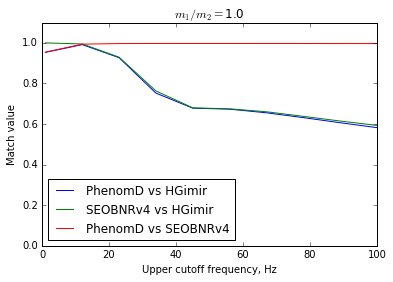

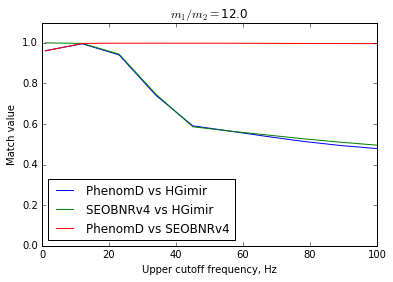

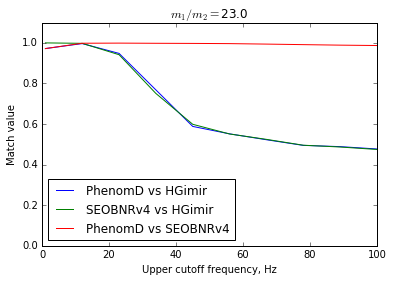

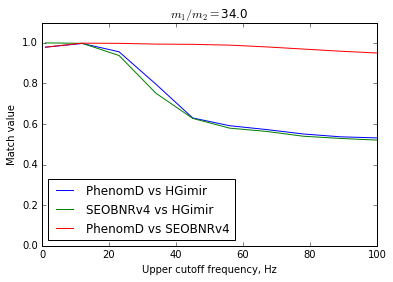

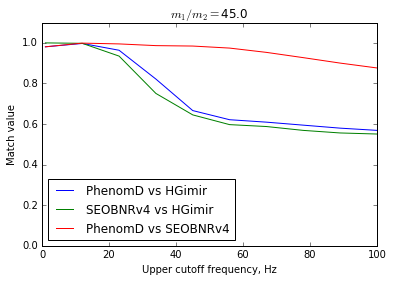

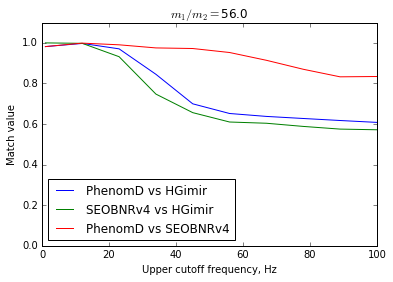

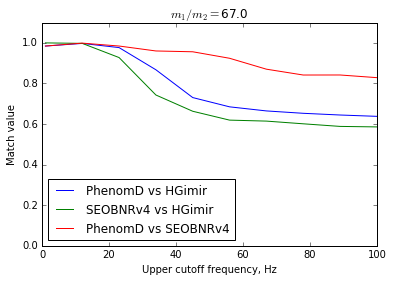

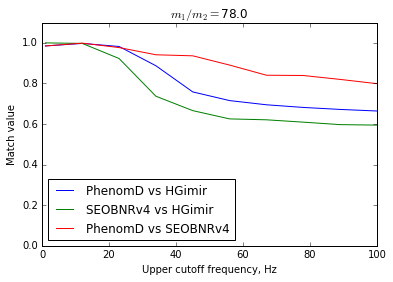

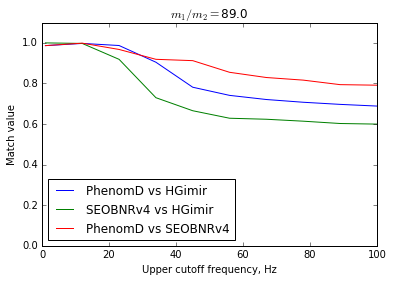

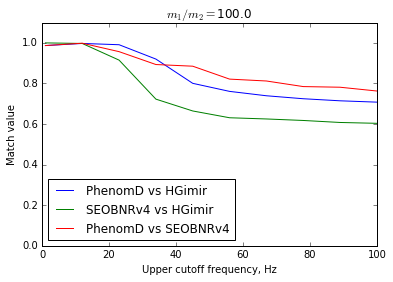

In [93]:
for q in q_list:
    d_vs_eobv4 = compute_match_by_freq(upper_f_list=upper_f_list, mass_ratio=q)
    d_vs_hgimi = compute_match_by_freq(upper_f_list=upper_f_list, approx1="IMRPhenomD", approx2='HGimri', mass_ratio=q)
    eobv4_vs_hgimi = compute_match_by_freq(upper_f_list=upper_f_list, approx1="SEOBNRv4", approx2='HGimri', mass_ratio=q)
    
    pylab.plot(q_list, d_vs_hgimi, label="PhenomD vs HGimir")
    pylab.plot(q_list, eobv4_vs_hgimi, label="SEOBNRv4 vs HGimir")
    pylab.plot(q_list, d_vs_eobv4, label="PhenomD vs SEOBNRv4")

    pylab.xlabel('Upper cutoff frequency, Hz')
    pylab.ylabel('Match value')
    pylab.legend(loc='lower left')

    pylab.ylim((0.0, 1.1))
    
    pylab.title(r"$m_{1} / m_{2} = $" + str(q))
    pylab.show()